**Packages**

In [73]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import sklearn

import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer, normalize


import os

import scipy

**Helper Functions**

In [74]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [75]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [76]:
def plot_f1_macro(history):
    plt.plot(history.history['f1_macro'], label='train_f1')
    plt.plot(history.history['val_f1_macro'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_macro']),
                max(history.history['val_f1_macro'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Macro F1 Score')
    plt.legend()
    plt.grid(True)

In [77]:
def plot_f1_weighted(history):
    plt.plot(history.history['f1_weighted'], label='train_f1')
    plt.plot(history.history['val_f1_weighted'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1_weighted']),
                max(history.history['val_f1_weighted'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Weighted F1 Score')
    plt.title('Weighted F1 Score')
    plt.legend()
    plt.grid(True)

In [78]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [79]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [80]:
x_train, x_val, y_train, y_val = train_test_split(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
2732,2948,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,2945,4.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,7123,1.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,12171,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,1096,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
historical_test = tiles_test['Collisions_Historical']
x_test = tiles_test.drop(['Tile_ID','bins_numeric','Collisions_Historical'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,94102,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [83]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [84]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(6700, 148, 188, 4)

In [85]:
historical_train = x_train['Collisions_Historical']
x_train = x_train.drop(['Tile_ID', 'Collisions_Historical'], axis = 1)

In [86]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
#     images_mini = normalize(images_mini.reshape(6700,-1))
    
    return images_mini

In [87]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1676, 148, 188, 4)

In [88]:
historical_val = x_val['Collisions_Historical']
x_val = x_val.drop(['Tile_ID', 'Collisions_Historical'], axis = 1)

In [89]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [90]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [91]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(6700, 1, 1, 38)

In [92]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1676, 1, 1, 38)

In [93]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 38)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.9.0: Adding historical at very end**

In [94]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [95]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [96]:
street_mini_2 = [] 
for k in range(len(street)):
    for i in range(50): 
        for j in range(50):
            street_mini_2.append(street[k])
street_mini_2 = np.reshape(street_mini_2, (len(street),50,50,38))
np.shape(street_mini_2)

(6700, 50, 50, 38)

In [97]:
street_mini_2_v = [] 
for k in range(len(street_v)):
    for i in range(50): 
        for j in range(50):
            street_mini_2_v.append(street_v[k])
street_mini_2_v = np.reshape(street_mini_2_v, (len(street_v),50,50,38))
np.shape(street_mini_2_v)

(1676, 50, 50, 38)

In [98]:
historical_train = np.array(historical_train).astype('float32').reshape(len(historical_train),1)

In [99]:
historical_val = np.array(historical_val).astype('float32').reshape(len(historical_val),1)

In [100]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(50,50,38), name='Input_Street') 
    input3 = tf.keras.layers.Input(shape=(1), name='Input_Historical') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(6, (3,3), activation="relu")(input1) # layers = street data dimension, changed dimensions to be according to paper
    pooling = tf.keras.layers.MaxPooling2D((99, 139), strides=1)(cnn) #downsizing, per paper
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    cnn2 = tf.keras.layers.Conv2D(2, (3,3), activation="relu")(input2)
    street = tf.keras.models.Model(inputs=input2, outputs=cnn2)
    
    combined = tf.keras.layers.Concatenate(axis = 3, name = "combined1")([images.output, street.output])
    #combined = tf.keras.layers.Add()([images.output, street.output])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    #resnet = resnet18(combined)
    
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(combined) # layers = street data dimension
    
    x = layers.GlobalAveragePooling2D(name='avgpool')(cnn)
    
    combined = tf.keras.layers.Concatenate(axis = 1, name = "combined2")([x, input3])
    
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(combined) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2, input3], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1_m = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1_macro',
    )

f1_w = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'weighted',
    threshold = None,
    name = 'f1_weighted',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning rate defined by scheduler
    loss='categorical_crossentropy',
    metrics = ['accuracy', keras.metrics.Precision(), f1_m, f1_w])

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# define the checkpoint
filepath = "model.17"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch < 8:
        return 0.0001
    elif epoch < 13:
        return 0.00001
    else:
        return 0.000001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = cnn_model.fit(
    [images_mini_v, street_mini_2_v, historical_val],
    y_v,
    epochs=15,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_2_v, historical_val], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 146, 186, 6)  222         ['Input_Images[0][0]']           
                                                                                                  
 Input_Street (InputLayer)      [(None, 50, 50, 38)  0           []                               
                                ]                                                                 
                                                                                           

INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 834s 16s/step - loss: 2.2974 - accuracy: 0.0036 - precision_7: 0.0000e+00 - f1_macro: 0.0101 - f1_weighted: 2.4429e-04 - val_loss: 2.6742 - val_accuracy: 0.0030 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0083 - val_f1_weighted: 2.0231e-04 - lr: 1.0000e-04
Epoch 2/15
53/53 [==============================] - ETA: 0s - loss: 2.2570 - accuracy: 0.0030 - precision_7: 0.0000e+00 - f1_macro: 0.0079 - f1_weighted: 1.9462e-04 
Epoch 2: val_f1_weighted did not improve from 0.00020
53/53 [==============================] - 833s 16s/step - loss: 2.2570 - accuracy: 0.0030 - precision_7: 0.0000e+00 - f1_macro: 0.0079 - f1_weighted: 1.9462e-04 - val_loss: 2.5816 - val_accuracy: 0.0024 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0065 - val_f1_weighted: 1.4970e-04 - lr: 1.0000e-04
Epoch 3/15
53/53 [==============================] - ETA: 0s - loss: 2.2191 - accuracy: 0.0024 - precision_7: 0.0000e+00 - f1_macro: 0.0051 - f1_weighted: 1.2633e-04 
Epoch 3: v

INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 831s 16s/step - loss: 2.1473 - accuracy: 0.0024 - precision_7: 0.0000e+00 - f1_macro: 0.0055 - f1_weighted: 1.6851e-04 - val_loss: 2.3467 - val_accuracy: 0.0024 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0062 - val_f1_weighted: 2.1442e-04 - lr: 1.0000e-04
Epoch 6/15
53/53 [==============================] - ETA: 0s - loss: 2.1168 - accuracy: 0.0018 - precision_7: 0.0000e+00 - f1_macro: 0.0034 - f1_weighted: 6.7546e-05 
Epoch 6: val_f1_weighted did not improve from 0.00021
53/53 [==============================] - 826s 16s/step - loss: 2.1168 - accuracy: 0.0018 - precision_7: 0.0000e+00 - f1_macro: 0.0034 - f1_weighted: 6.7546e-05 - val_loss: 2.2776 - val_accuracy: 0.0018 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0035 - val_f1_weighted: 6.9289e-05 - lr: 1.0000e-04
Epoch 7/15
53/53 [==============================] - ETA: 0s - loss: 2.0907 - accuracy: 0.0018 - precision_7: 0.0000e+00 - f1_macro: 0.0038 - f1_weighted: 7.5104e-05 
Epoch 7: v

INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 832s 16s/step - loss: 2.0599 - accuracy: 0.0024 - precision_7: 0.0000e+00 - f1_macro: 0.0040 - f1_weighted: 0.0013 - val_loss: 2.1454 - val_accuracy: 0.0030 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0047 - val_f1_weighted: 0.0025 - lr: 1.0000e-04
Epoch 9/15
53/53 [==============================] - ETA: 0s - loss: 2.0370 - accuracy: 0.0030 - precision_7: 0.0000e+00 - f1_macro: 0.0047 - f1_weighted: 0.0025 
Epoch 9: val_f1_weighted improved from 0.00247 to 0.00366, saving model to model.17


INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 832s 16s/step - loss: 2.0370 - accuracy: 0.0030 - precision_7: 0.0000e+00 - f1_macro: 0.0047 - f1_weighted: 0.0025 - val_loss: 2.1387 - val_accuracy: 0.0036 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0049 - val_f1_weighted: 0.0037 - lr: 1.0000e-05
Epoch 10/15
53/53 [==============================] - ETA: 0s - loss: 2.0343 - accuracy: 0.0036 - precision_7: 0.0000e+00 - f1_macro: 0.0049 - f1_weighted: 0.0037 
Epoch 10: val_f1_weighted did not improve from 0.00366
53/53 [==============================] - 831s 16s/step - loss: 2.0343 - accuracy: 0.0036 - precision_7: 0.0000e+00 - f1_macro: 0.0049 - f1_weighted: 0.0037 - val_loss: 2.1320 - val_accuracy: 0.0036 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0049 - val_f1_weighted: 0.0037 - lr: 1.0000e-05
Epoch 11/15
53/53 [==============================] - ETA: 0s - loss: 2.0315 - accuracy: 0.0042 - precision_7: 0.0000e+00 - f1_macro: 0.0051 - f1_weighted: 0.0048 
Epoch 11: val_f1_weighted impro

INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 821s 15s/step - loss: 2.0315 - accuracy: 0.0042 - precision_7: 0.0000e+00 - f1_macro: 0.0051 - f1_weighted: 0.0048 - val_loss: 2.1258 - val_accuracy: 0.0054 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0054 - val_f1_weighted: 0.0072 - lr: 1.0000e-05
Epoch 12/15
53/53 [==============================] - ETA: 0s - loss: 2.0289 - accuracy: 0.0054 - precision_7: 0.0000e+00 - f1_macro: 0.0054 - f1_weighted: 0.0072 
Epoch 12: val_f1_weighted improved from 0.00721 to 0.00840, saving model to model.17


INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 821s 15s/step - loss: 2.0289 - accuracy: 0.0054 - precision_7: 0.0000e+00 - f1_macro: 0.0054 - f1_weighted: 0.0072 - val_loss: 2.1191 - val_accuracy: 0.0060 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0056 - val_f1_weighted: 0.0084 - lr: 1.0000e-05
Epoch 13/15
53/53 [==============================] - ETA: 0s - loss: 2.0260 - accuracy: 0.0084 - precision_7: 0.0000e+00 - f1_macro: 0.0062 - f1_weighted: 0.0131 
Epoch 13: val_f1_weighted improved from 0.00840 to 0.01662, saving model to model.17


INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 830s 16s/step - loss: 2.0260 - accuracy: 0.0084 - precision_7: 0.0000e+00 - f1_macro: 0.0062 - f1_weighted: 0.0131 - val_loss: 2.1122 - val_accuracy: 0.0101 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0066 - val_f1_weighted: 0.0166 - lr: 1.0000e-05
Epoch 14/15
53/53 [==============================] - ETA: 0s - loss: 2.0239 - accuracy: 0.0101 - precision_7: 0.0000e+00 - f1_macro: 0.0066 - f1_weighted: 0.0166 
Epoch 14: val_f1_weighted did not improve from 0.01662
53/53 [==============================] - 820s 15s/step - loss: 2.0239 - accuracy: 0.0101 - precision_7: 0.0000e+00 - f1_macro: 0.0066 - f1_weighted: 0.0166 - val_loss: 2.1115 - val_accuracy: 0.0101 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0066 - val_f1_weighted: 0.0166 - lr: 1.0000e-06
Epoch 15/15
53/53 [==============================] - ETA: 0s - loss: 2.0236 - accuracy: 0.0107 - precision_7: 0.0000e+00 - f1_macro: 0.0067 - f1_weighted: 0.0178 
Epoch 15: val_f1_weighted impro

INFO:tensorflow:Assets written to: model.17/assets


INFO:tensorflow:Assets written to: model.17/assets


53/53 [==============================] - 834s 16s/step - loss: 2.0236 - accuracy: 0.0107 - precision_7: 0.0000e+00 - f1_macro: 0.0067 - f1_weighted: 0.0178 - val_loss: 2.1108 - val_accuracy: 0.0107 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0067 - val_f1_weighted: 0.0178 - lr: 1.0000e-06


In [101]:
# saving last epoch model just in case 
cnn_model.save('model.17.last.epoch')

INFO:tensorflow:Assets written to: model.17.last.epoch/assets


INFO:tensorflow:Assets written to: model.17.last.epoch/assets


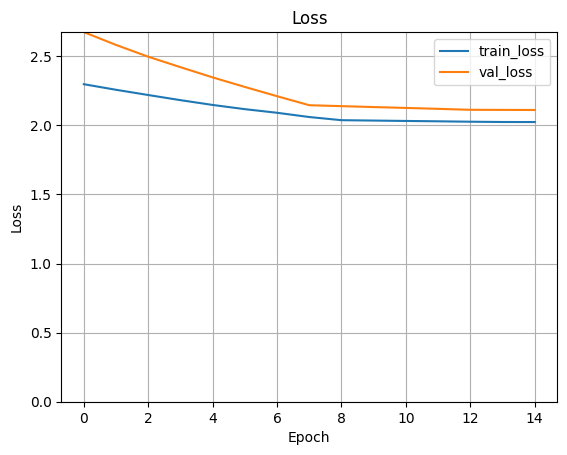

In [102]:
plot_loss(history)

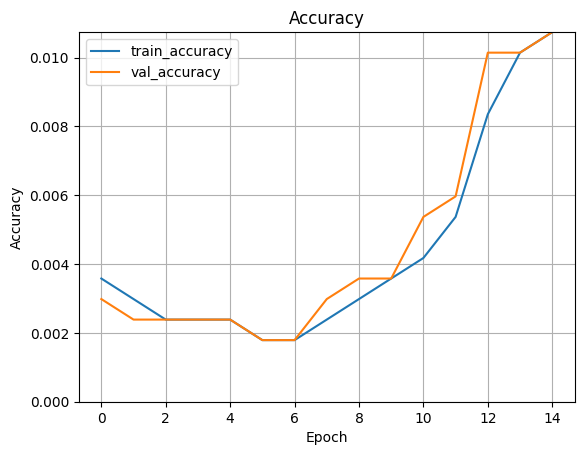

In [103]:
plot_accuracy(history)

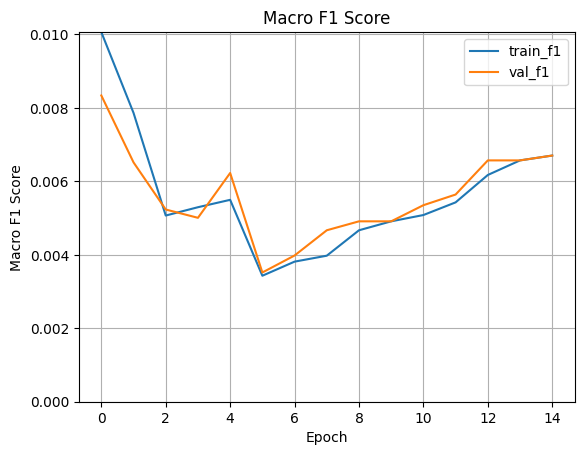

In [104]:
plot_f1_macro(history)

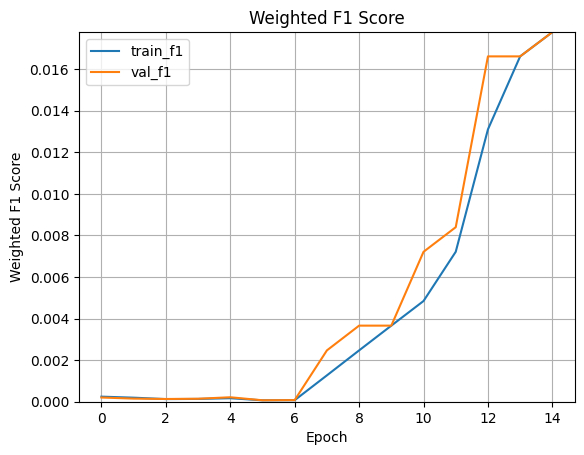

In [105]:
plot_f1_weighted(history)

**Continuing to train model 17**

In [111]:
# load the model
filepath = "model.17"
best_model = load_model(filepath)

In [113]:
#define the checkpoint
filepath = "model.17.1"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1_weighted', verbose=1, save_best_only=True, mode='max')
callbacks_check = checkpoint

def scheduler(epoch, lr):
    if epoch < 8:
        return 0.0001
    elif epoch < 18:
        return 0.00001
    else:
        return 0.000001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

history = best_model.fit(
    [images_mini, street_mini_2, historical_train],
    y_t,
    epochs=20,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_2_v, historical_val], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights,
    callbacks=[callback, callbacks_check],
    )

Epoch 1/20
210/210 [==============================] - ETA: 0s - loss: 3.5258 - accuracy: 0.2900 - precision_7: 0.0000e+00 - f1_macro: 0.0513 - f1_weighted: 0.4100 
Epoch 1: val_f1_weighted improved from -inf to 0.69244, saving model to model.17.1


INFO:tensorflow:Assets written to: model.17.1/assets


INFO:tensorflow:Assets written to: model.17.1/assets


210/210 [==============================] - 3261s 16s/step - loss: 3.5258 - accuracy: 0.2900 - precision_7: 0.0000e+00 - f1_macro: 0.0513 - f1_weighted: 0.4100 - val_loss: 1.9468 - val_accuracy: 0.6527 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0837 - val_f1_weighted: 0.6924 - lr: 1.0000e-04
Epoch 2/20
210/210 [==============================] - ETA: 0s - loss: 3.4586 - accuracy: 0.6888 - precision_7: 0.0000e+00 - f1_macro: 0.0864 - f1_weighted: 0.7034 
Epoch 2: val_f1_weighted improved from 0.69244 to 0.72744, saving model to model.17.1


INFO:tensorflow:Assets written to: model.17.1/assets


INFO:tensorflow:Assets written to: model.17.1/assets


210/210 [==============================] - 3254s 15s/step - loss: 3.4586 - accuracy: 0.6888 - precision_7: 0.0000e+00 - f1_macro: 0.0864 - f1_weighted: 0.7034 - val_loss: 1.8293 - val_accuracy: 0.7261 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0888 - val_f1_weighted: 0.7274 - lr: 1.0000e-04
Epoch 3/20
210/210 [==============================] - ETA: 0s - loss: 3.3908 - accuracy: 0.7367 - precision_7: 0.0000e+00 - f1_macro: 0.0910 - f1_weighted: 0.7219 
Epoch 3: val_f1_weighted improved from 0.72744 to 0.74594, saving model to model.17.1


INFO:tensorflow:Assets written to: model.17.1/assets


INFO:tensorflow:Assets written to: model.17.1/assets


210/210 [==============================] - 3251s 15s/step - loss: 3.3908 - accuracy: 0.7367 - precision_7: 0.0000e+00 - f1_macro: 0.0910 - f1_weighted: 0.7219 - val_loss: 1.7294 - val_accuracy: 0.7607 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.0972 - val_f1_weighted: 0.7459 - lr: 1.0000e-04
Epoch 4/20
210/210 [==============================] - ETA: 0s - loss: 3.3213 - accuracy: 0.7501 - precision_7: 0.0000e+00 - f1_macro: 0.0976 - f1_weighted: 0.7304 
Epoch 4: val_f1_weighted improved from 0.74594 to 0.75553, saving model to model.17.1


INFO:tensorflow:Assets written to: model.17.1/assets


INFO:tensorflow:Assets written to: model.17.1/assets


210/210 [==============================] - 3242s 15s/step - loss: 3.3213 - accuracy: 0.7501 - precision_7: 0.0000e+00 - f1_macro: 0.0976 - f1_weighted: 0.7304 - val_loss: 1.6520 - val_accuracy: 0.7739 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.1044 - val_f1_weighted: 0.7555 - lr: 1.0000e-04
Epoch 5/20
210/210 [==============================] - ETA: 0s - loss: 3.2594 - accuracy: 0.7645 - precision_7: 1.0000 - f1_macro: 0.1082 - f1_weighted: 0.7419 
Epoch 5: val_f1_weighted improved from 0.75553 to 0.76422, saving model to model.17.1


INFO:tensorflow:Assets written to: model.17.1/assets


INFO:tensorflow:Assets written to: model.17.1/assets


210/210 [==============================] - 3247s 15s/step - loss: 3.2594 - accuracy: 0.7645 - precision_7: 1.0000 - f1_macro: 0.1082 - f1_weighted: 0.7419 - val_loss: 1.5910 - val_accuracy: 0.7739 - val_precision_7: 0.0000e+00 - val_f1_macro: 0.1163 - val_f1_weighted: 0.7642 - lr: 1.0000e-04
Epoch 6/20
210/210 [==============================] - ETA: 0s - loss: 3.2065 - accuracy: 0.7654 - precision_7: 0.5000 - f1_macro: 0.1267 - f1_weighted: 0.7469 
Epoch 6: val_f1_weighted did not improve from 0.76422
210/210 [==============================] - 3234s 15s/step - loss: 3.2065 - accuracy: 0.7654 - precision_7: 0.5000 - f1_macro: 0.1267 - f1_weighted: 0.7469 - val_loss: 1.5496 - val_accuracy: 0.7667 - val_precision_7: 0.6667 - val_f1_macro: 0.1156 - val_f1_weighted: 0.7604 - lr: 1.0000e-04
Epoch 7/20
210/210 [==============================] - ETA: 0s - loss: 3.1077 - accuracy: 0.7422 - precision_7: 0.3944 - f1_macro: 0.1263 - f1_weighted: 0.7367 
Epoch 8: val_f1_weighted did not improve fro

**Analysis of Best Checkpoint Model**

In [106]:
# load the model
filepath = "model.17.1"
best_model = load_model(filepath)

In [107]:
y_pred = best_model.predict([images_mini_v, street_mini_2_v, historical_val])
y_pred

53/53 [==============================] - 17s 312ms/step


array([[0.1302383 , 0.10276724, 0.07860808, ..., 0.13565946, 0.07181085,
        0.04313813],
       [0.11021075, 0.09527924, 0.08693033, ..., 0.11930547, 0.07587613,
        0.02239662],
       [0.13586953, 0.10566736, 0.07882541, ..., 0.14145829, 0.07198203,
        0.03989727],
       ...,
       [0.1075137 , 0.09268624, 0.08878498, ..., 0.12395209, 0.07292453,
        0.02471371],
       [0.1435596 , 0.11083559, 0.07388338, ..., 0.13915446, 0.07653515,
        0.02979983],
       [0.13335972, 0.10322106, 0.07743241, ..., 0.1415297 , 0.07117875,
        0.04099482]], dtype=float32)

In [108]:
pred_values = []
for i in y_pred: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values.append(index[0])
pred_values[0:5]

[4, 4, 8, 4, 4]

In [109]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

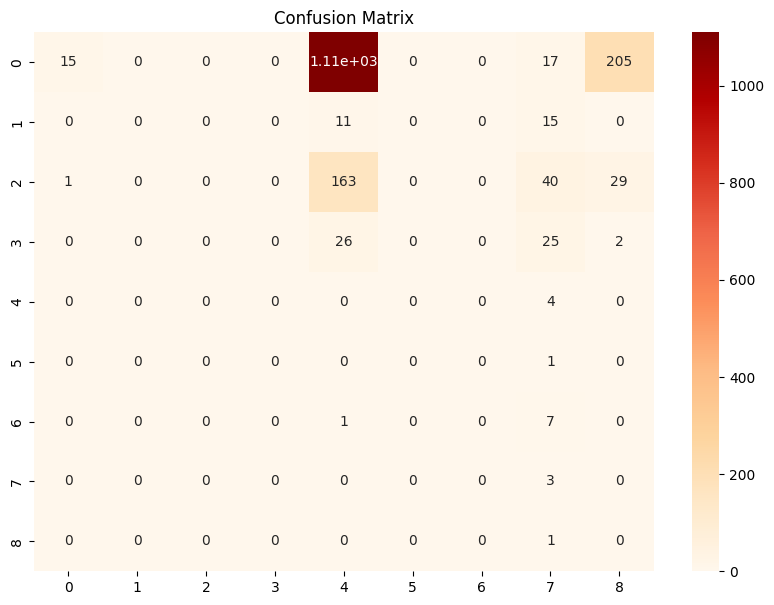

In [110]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values)
ind = max(max(np.unique(y_true)), max(np.unique(pred_values))) + 1
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")